## Прогнозирование продаж целевого товара для супермаркета X



Данное тестовое задание предназначено для проверки наших навыков программирования на python, умения разбираться в новых темах, написания SQL запросов и умения анализировать данные. Предоставленные данные являются реальными данными сетевого супермаркета Х. Выполнив тестовое задание, мы можем использовать результаты для расширения нашего портфолио. 

Задание:

1.	Сделать необходимые SQL запросы к тестовой базе данных ClickHouse о продажах в магазине Х. 

Познакомиться со структурой БД можно по ссылке (http://ui.tabix.io/#!/login)

http://82.148.25.91:8123

Логин ro_test

Пароль qwerty


2.	По результатам запросов провести анализ данных и сделать предсказания продаж в штуках на последующую неделю для товара 7d185936-7a60-11eb-ba7f-4a6a34607ded. Для доступа к БД использовать следующие параметры:

host='82.148.25.91',

user='ro_test',

password='qwerty',

database='test'


В качестве решения от нас ждут .csv файл с колонками "dates", "quantities" и сам файл с кодом (предпочтительнее .ipynb с визуализацией, но принимается и .py с последующими объяснениями на тех. интервью), отправленные на почту em@imprice.ai. От нас не ожидают точного предсказания, а будут смотреть на ход решения данной задачи и используемые методы. Также будут оценивать и частично выполненное задание, если возникнут трудности с итоговым решением. 

В случае вопросов, можно обращаться к Евгению через телеграм @em_imprice.
    
    

___
    
Часть 1. Изучение общей информации
    
1.  Импорт необходимых библиотек для работы с данными, загрузка датасета
2. Изучение данных, получение общей информации
3. Анализ временного ряда
4. Создание дамми-модели
5. Вывод
    
Часть 2. Работа с классическими ML алгоритмами

1. Обучение классических ML алгоритмов
2. Тестирование классических ML алгоритмов
3. Прогнозирование будущих продаж с использованием класических ML алгоритмов
4. Вывод
    
Часть 3. Работа с нейронными сетями   
    
1. Создание нейронной сети с использованием LSTM
2. Тестирование нейронной сети
3. Прогнозирование будущих продаж с использованием нейронной сети
4. Вывод  
    
Часть 4. Использование базовых моделей
    
1. Использование модели SARIMAX

    
Общий вывод о проделанной работе   
____

## Часть 1. Изучение общей информации 

<a id='Импорт необходимых библиотек для работы с данными, загрузка датасета'>

### Импорт необходимых библиотек для работы с данными, загрузка датасета

Импортируем необходимые библиотеки, убираем ограничения на количество столбцов, отключаем предупреждения.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from clickhouse_driver import Client
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.simplefilter('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [4]:
import statsmodels.api as sm

Подключаемся к базе, создаем запрос, приводим результат к удобочитаемому виду.

In [5]:
client = Client(host='82.148.25.91',
                user='ro_test',
                password='qwerty',
                database='test')

In [6]:
result = client.execute("SELECT DATE(date) AS dates, SUM(quantity) AS quantities "
                        "FROM test.sales " 
                        "WHERE item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded' "
                        "GROUP BY dates ORDER BY dates ASC")

In [7]:
cols = ['dates', 'quantities']
raw_data = pd.DataFrame(result, columns = cols)

Откорректируем типы данных.

In [8]:
raw_data['quantities'] = raw_data['quantities'].astype(str).astype(int)

Проверяем вывод.

In [9]:
raw_data.head()

,dates,quantities
0,2021-01-04,9
1,2021-01-05,37
2,2021-01-06,30
3,2021-01-07,34
4,2021-01-08,38


In [10]:
raw_data.tail()

,dates,quantities
348,2021-12-26,15
349,2021-12-27,7
350,2021-12-28,9
351,2021-12-29,11
352,2021-12-30,8


<a id='Изучение данных, получение общей информации'></a>

### Изучение данных, получение общей информации

In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dates       353 non-null    object
 1   quantities  353 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 4.3+ KB


In [12]:
raw_data.describe(include='all')

,dates,quantities
count,353,353.000000
unique,353,NaN
top,2021-06-20,NaN
freq,1,NaN
mean,NaN,27.147309
std,NaN,15.824889
min,NaN,2.000000
25%,NaN,14.000000
50%,NaN,24.000000
75%,NaN,37.000000


Проиллюстрируем на наши данные.

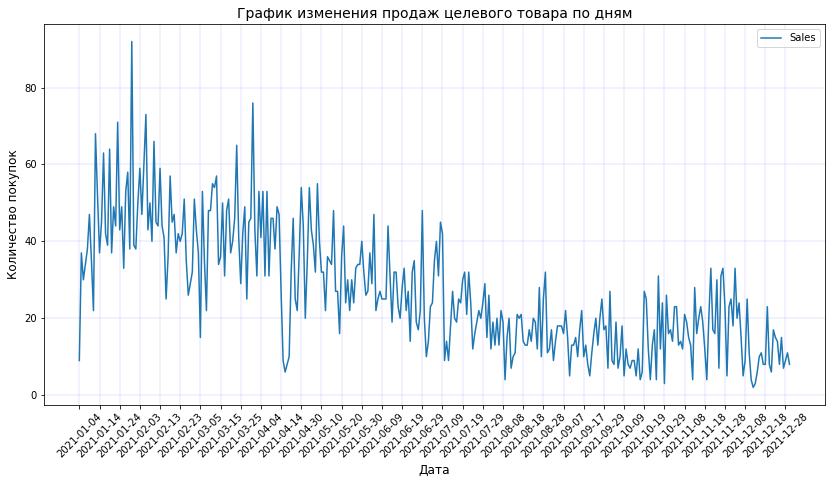

In [13]:
plt.figure(figsize = (14, 7))
plt.plot(raw_data['quantities'], label = 'Sales');
plt.title('График изменения продаж целевого товара по дням', fontsize=14)
plt.xticks(range(0, raw_data.shape[0], 10), raw_data['dates'].loc[::10], rotation = 45)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество покупок', fontsize=12)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.legend(fontsize=10)
plt.show()

<a id='Анализ временного ряда'>

### Анализ временного ряда 

In [14]:
df_copy = raw_data.copy()

Также оценим данные на основе скользящих средних и среднеквадротичных отклонений, возьмем средние значения за неделю.

In [15]:
df_copy['rolling_mean'] = df_copy['quantities'].shift().rolling(7).mean()
df_copy['std'] = df_copy['quantities'].rolling(7).std()
df_copy = df_copy.dropna()

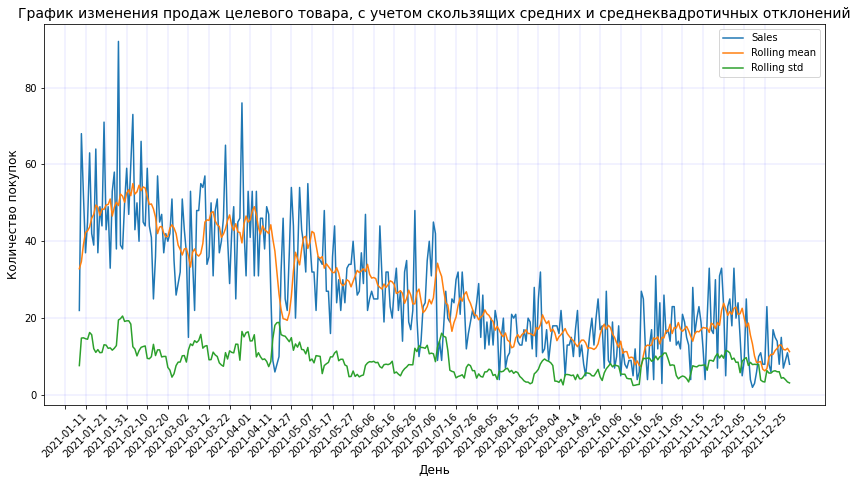

In [16]:
plt.figure(figsize = (14, 7))
plt.plot(df_copy['quantities'], label =  'Sales');
plt.plot(df_copy['rolling_mean'], label = 'Rolling mean');
plt.plot(df_copy['std'], label = 'Rolling std');
plt.xticks(range(0, df_copy.shape[0], 10), df_copy['dates'].loc[::10], rotation = 45)
plt.title('График изменения продаж целевого товара, с учетом скользящих средних и среднеквадротичных отклонений', fontsize=14)
plt.xlabel('День', fontsize=12)
plt.ylabel('Количество покупок', fontsize=12)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.legend(fontsize=10)
plt.show()

In [17]:
df_copy['dates']= pd.to_datetime(df_copy['dates'])
df_copy = df_copy.set_index('dates')

In [18]:
data = df_copy['quantities']['2021-01':'2021-12'].resample('1D').sum()

Разобьем временной ряд на составляющие для дальнейшего анализа.

In [19]:
decomposed = seasonal_decompose(data)

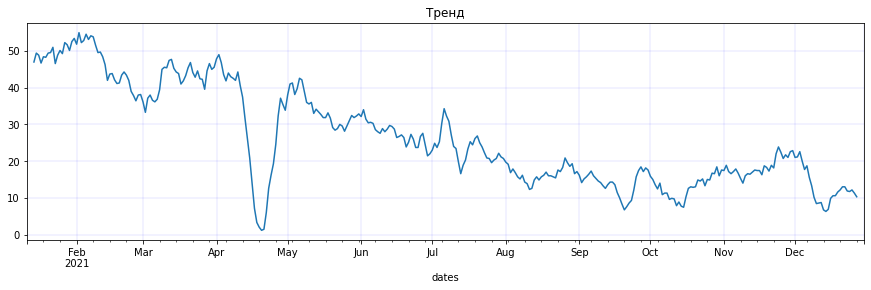

In [20]:
decomposed.trend.plot(title='Тренд', figsize=(15, 4));
plt.grid(color='b', linestyle='-', linewidth=0.1);

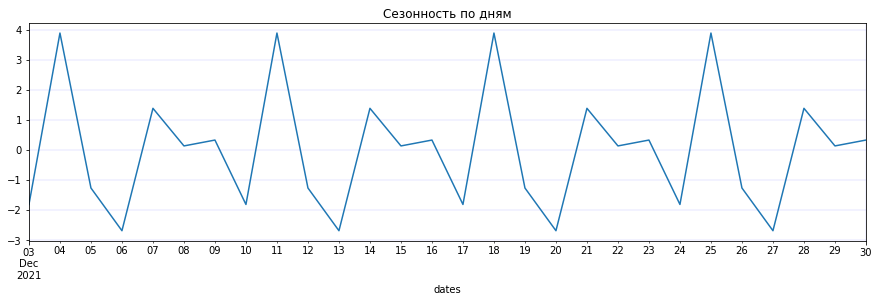

In [21]:
decomposed.seasonal.tail(28).plot(title='Сезонность по дням', figsize=(15,4));
plt.grid(color='b', linestyle='-', linewidth=0.1);

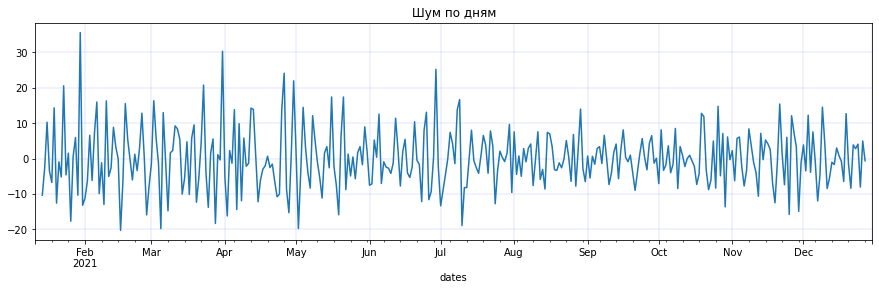

In [22]:
decomposed.resid.plot(title='Шум по дням', figsize=(15,4));
plt.grid(color='b', linestyle='-', linewidth=0.1);

На графике трендов наблюдаем нисходящий тренд, который может быть связан с потерей покупателями интереса к данному продукту. На графике сезонности наблюдается периодичность в одну неделю. График случайного шума стационарен.

Теперь проанализируем график нулевого тренда.

In [23]:
df2_copy = df_copy.copy()
df2_copy -= df2_copy.shift()

In [24]:
df2_copy['rolling_mean'] = df2_copy['quantities'].rolling(7).mean()
df2_copy['std'] = df2_copy['quantities'].rolling(7).std()

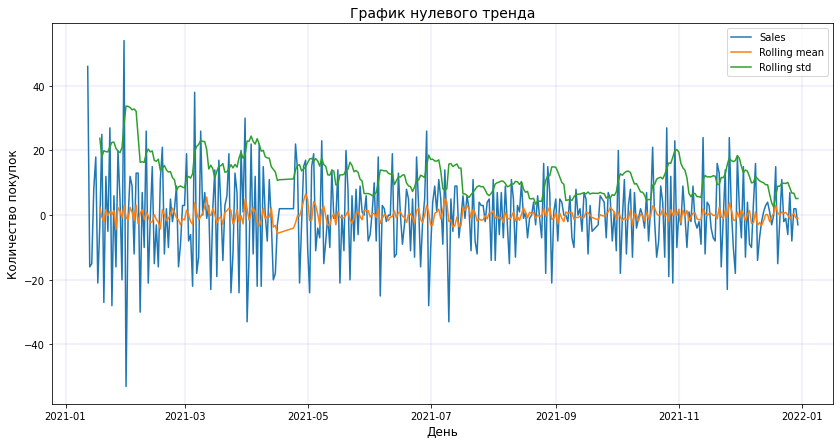

In [25]:
plt.figure(figsize = (14, 7))
plt.plot(df2_copy['quantities'], label =  'Sales');
plt.plot(df2_copy['rolling_mean'], label = 'Rolling mean');
plt.plot(df2_copy['std'], label = 'Rolling std');
plt.title('График нулевого тренда', fontsize=14)
plt.xlabel('День', fontsize=12)
plt.ylabel('Количество покупок', fontsize=12)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.legend(fontsize=10)
plt.show()

На графике нулевого тренда, как и на графике шума, получен стационарный ряд, что позволяет делать вывод о возможности прогнозирования данного временного ряда.

Также проверим стационарность нашего ряда на adfuller тесте.

In [26]:
dftest = adfuller(df2_copy.dropna()['quantities'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -10.820416347685029
2. P-Value :  1.8116180011789378e-19
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 331
5. Critical Values :
	 1% :  -3.4502615951739393
	 5% :  -2.8703117734117742
	 10% :  -2.5714433728242714


P-Value почти равен нулю, порог статистической значимости в 0.05 не преодолен  - ряд стационарен.

<a id='Создание дамми-модели'>

### <p style="text-align:center"> Создание дамми-модели </p>

Теперь создадам дамми-модель, которая будет ориентиром точности наших моделей. В качестве метрики будем использовать хорошо интерпретируемую RMSE.

In [27]:
df_train, df_test = train_test_split(raw_data['quantities'], shuffle=False, test_size=0.1)

In [28]:
pred_median = np.ones(df_test.shape) * df_train.median()
rmse = np.sqrt(mean_squared_error(df_test, pred_median))
rmse

14.87540849112312

In [29]:
pred_previous = df_test.shift()
pred_previous.iloc[0] = df_train.iloc[-1]
rmse = np.sqrt(mean_squared_error(df_test, pred_previous))
rmse

10.279429296739517

В качестве основной дамми модели примем вторую.

<a id='Вывод 1'>

### <p style="text-align:center"> Вывод </p>

##### В ходе изучения общей информации было выполнено:


___



1. Импортированы необходимые библиотеки, сформирован запрос, данные получены.


2. Данные представляют собой количество проданного товара за соответствующую дату в 2021 году.


3. Произведен анализ временного ряда - выявлены тренд, сезонность и случайный шум данных, построен график нулевого тренда; доказано, что временной ряд обладает стационарной составляющей.


4. Создана дамми-модель в качестве ориентира качества моделей.


___


 ## Часть 2. Работа с классическими ML алгоритмами

<a id='Обучение классических ML алгоритмов.'>

### Обучение классических ML алгоритмов

Создадим несколько дополнительных признаков для обучения моделей. Т.к. у нас есть недельная сезонность попробуем использовать данные о дне недели в качестве признака. Также будем использовать lag в три недели для учета продаж в предыдущие дни и для учета общего тренда.

In [30]:
df = raw_data.copy()

In [31]:
df['dates']= pd.to_datetime(df['dates'])
df = df.set_index('dates')

In [32]:
def make_features(data, max_lag):
    
    '''Function creates new features, with max_lag provied, 
    is made to take into acount overall trand of the data.'''
    
    data['dayofweek'] = data.index.dayofweek
    data['dayofmonth'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['quantities'].shift(lag)

In [33]:
make_features(df, 21)

Проверяем.

In [34]:
df.head(10).T

dates,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,2021-01-11,2021-01-12,2021-01-13
quantities,9.0,37.0,30.0,34.0,38.0,47.0,35.0,22.0,68.0,52.0
dayofweek,0.0,1.0,2.0,3.0,4.0,5.0,6.0,0.0,1.0,2.0
dayofmonth,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
lag_1,NaN,9.0,37.0,30.0,34.0,38.0,47.0,35.0,22.0,68.0
lag_2,NaN,NaN,9.0,37.0,30.0,34.0,38.0,47.0,35.0,22.0
lag_3,NaN,NaN,NaN,9.0,37.0,30.0,34.0,38.0,47.0,35.0
lag_4,NaN,NaN,NaN,NaN,9.0,37.0,30.0,34.0,38.0,47.0
lag_5,NaN,NaN,NaN,NaN,NaN,9.0,37.0,30.0,34.0,38.0
lag_6,NaN,NaN,NaN,NaN,NaN,NaN,9.0,37.0,30.0,34.0
lag_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,37.0,30.0


Не забываем указать shuffle=False чтобы избежать путаницы в обучении.

In [35]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [36]:
X_train = train.drop(['quantities'], axis=1)
y_train = train['quantities']
X_test = test.drop(['quantities'],axis=1)
y_test = test['quantities']

Проверим размеры выборок.

In [37]:
print('Размер обучающей выборки:',X_train.shape)
print('Целевой признак обучающей выборки:', y_train.shape)
print('Размер тестовой выборки:', X_test.shape)
print('Целевой признак тестовой выборки:', y_test.shape)

Размер обучающей выборки: (296, 23)
Целевой признак обучающей выборки: (296,)
Размер тестовой выборки: (36, 23)
Целевой признак тестовой выборки: (36,)


#### Модель линейной регрессии.

In [38]:
linear_model = LinearRegression(n_jobs=-1)
linear_model.fit(X_train, y_train)
linear_model_predictions = linear_model.predict(X_train)

In [39]:
linear_rmse = np.sqrt(mean_squared_error(y_train, linear_model_predictions))
linear_rmse

9.43575001260875

RMSE линейной модели чуть лучше показателя дамми модели, однако нет возможности улучшить модель гиперпараметрами.

####  Модель случайного леса.

In [40]:
forest_model = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=4)
forest_model.fit(X_train, y_train)
forest_model_predictions = forest_model.predict(X_train)

In [41]:
forest_rmse = np.sqrt(mean_squared_error(y_train, forest_model_predictions))
forest_rmse

6.150525759403874

RMSE модели случайного леса лучше показателя дамми модели. Есть возможность улучшить модель гиперпараметрами, также есть риск переобучения.

####  LGBM 

In [42]:
lgbm_model = lgb.LGBMRegressor(task='train', learning_rate=0.05, verbose=200, objective='regression')

In [43]:
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')
lgbm_prediction = lgbm_model.predict(X_train, num_iteration = lgbm_model.best_iteration_)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.006169
[LightGBM] [Debug] init for col-wise cost 0.000022 seconds, init for row-wise cost 0.000977 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 296, number of used features: 23
[LightGBM] [Info] Start training from score 27.625000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[1]	valid_0's rmse: 15.8421	valid_0's l2: 250.971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[2]	valid_0's rmse: 15.5289	valid_0's l2: 241.148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Train

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[91]	valid_0's rmse: 10.0518	valid_0's l2: 101.039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 8
[92]	valid_0's rmse: 10.0671	valid_0's l2: 101.347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 7
[93]	valid_0's rmse: 10.0873	valid_0's l2: 101.754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[94]	valid_0's rmse: 10.0787	valid_0's l2: 101.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[95]	valid_0's rmse: 10.0735	valid_0's l2: 101.475
[LightGBM] [Warning] No further splits with po

In [44]:
lgbm_rmse = np.sqrt(mean_squared_error(y_train, lgbm_prediction))
lgbm_rmse

5.184309856178048

RMSE LGBM значительно лучше показателя дамми модели. Есть возможность улучшить модель гиперпараметрами, однако на больших объемах данных это может привести к значительному увеличению продолжительности обучения.

####  CatBoost 

In [45]:
catboost_model = CatBoostRegressor(iterations=100, learning_rate=0.05, depth=4)
catboost_model.fit(X_train, y_train)
catboost_model_prediction = catboost_model.predict(X_train)

0:	learn: 14.9257307	total: 162ms	remaining: 16.1s
1:	learn: 14.6052205	total: 164ms	remaining: 8.02s
2:	learn: 14.2849808	total: 165ms	remaining: 5.32s
3:	learn: 13.9682724	total: 166ms	remaining: 3.97s
4:	learn: 13.6994621	total: 166ms	remaining: 3.16s
5:	learn: 13.4139034	total: 167ms	remaining: 2.62s
6:	learn: 13.1264157	total: 168ms	remaining: 2.23s
7:	learn: 12.8727799	total: 169ms	remaining: 1.94s
8:	learn: 12.6425062	total: 170ms	remaining: 1.72s
9:	learn: 12.4214062	total: 171ms	remaining: 1.53s
10:	learn: 12.2076261	total: 172ms	remaining: 1.39s
11:	learn: 12.0295782	total: 173ms	remaining: 1.26s
12:	learn: 11.8515618	total: 173ms	remaining: 1.16s
13:	learn: 11.6681976	total: 174ms	remaining: 1.07s
14:	learn: 11.4965086	total: 175ms	remaining: 992ms
15:	learn: 11.3322486	total: 176ms	remaining: 923ms
16:	learn: 11.1694792	total: 177ms	remaining: 864ms
17:	learn: 11.0359536	total: 178ms	remaining: 810ms
18:	learn: 10.8890597	total: 179ms	remaining: 761ms
19:	learn: 10.7709542	

In [46]:
catboost_rmse = np.sqrt(mean_squared_error(y_train, catboost_model_prediction))
catboost_rmse

7.727038276491957

RMSE CatBoost модели лучше показателя дамми модели. Есть возможность улучшить модель гиперпараметрами, однако на больших объемах данных это может привести к значительному увеличению продолжительности обучения.

####  XGBoost 

In [47]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5, 
                             max_depth = 5, alpha = 10, n_estimators = 10)

In [48]:
xgb_model.fit(X_train, y_train)
xgb_model_prediction = xgb_model.predict(X_train)

In [49]:
xgb_rmse = np.sqrt(mean_squared_error(y_train, xgb_model_prediction))
xgb_rmse

4.397795034969702

RMSE XGBoost модели лучше показателя дамми модели. Есть возможность улучшить модель гиперпараметрами, однако это может привести к значительному увеличению продолжительности обучения.

<a id='Тестирование классических ML алгоритмов.'>

###  Тестирование классических ML алгоритмов 

In [50]:
models = [linear_model, forest_model, lgbm_model, catboost_model, xgb_model]
models_names = ['Linear Regression', 'Random Forest Regression', 'Light GBM', 'Catboost', 'XGBoost']

In [51]:
for i in range(len(models)):
    print('RMSE модели {}:'.format(models_names[i]), end = ' ')
    print((np.sqrt(mean_squared_error(y_test, models[i].predict(X_test)))).round(3))

RMSE модели Linear Regression: 8.843
RMSE модели Random Forest Regression: 9.613
RMSE модели Light GBM: 10.104
RMSE модели Catboost: 9.039
RMSE модели XGBoost: 9.448


Точность алгоритмов в целом сопоставима. Проиллюстрируем тестовые предсказания моделей.

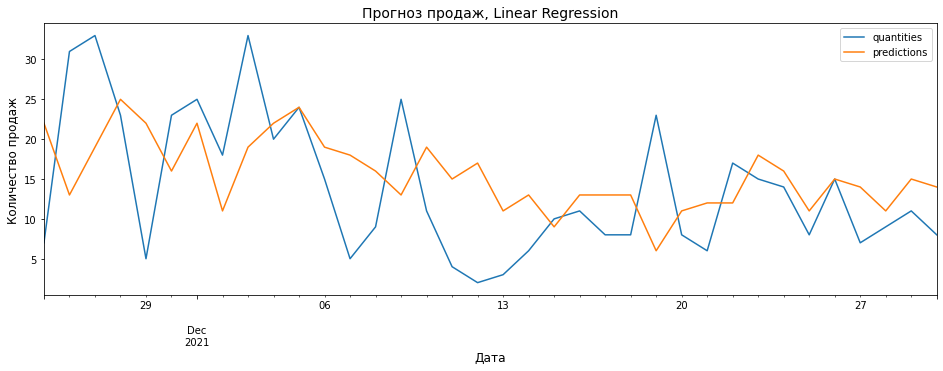

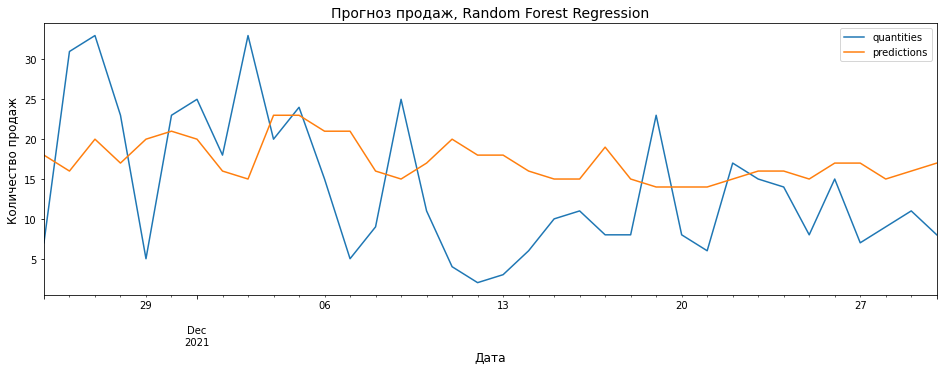

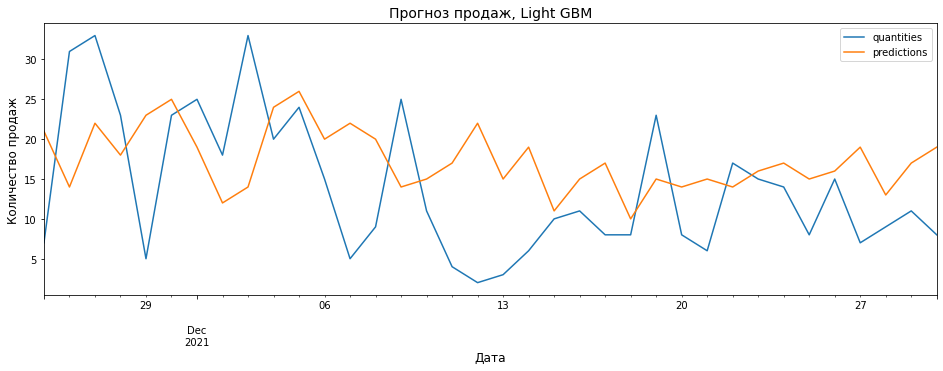

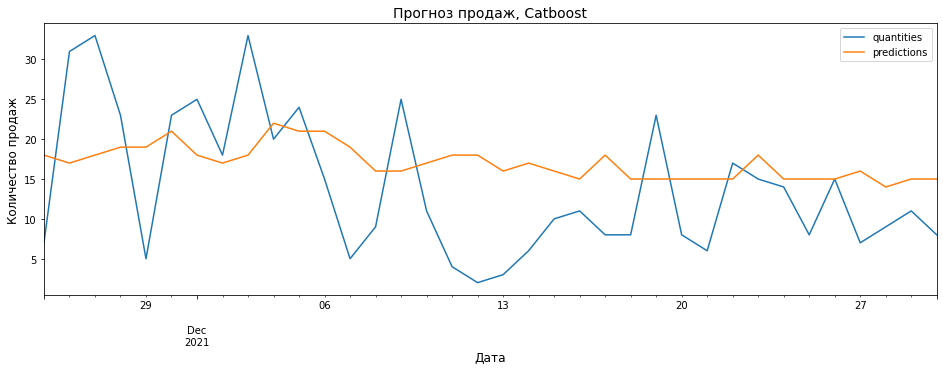

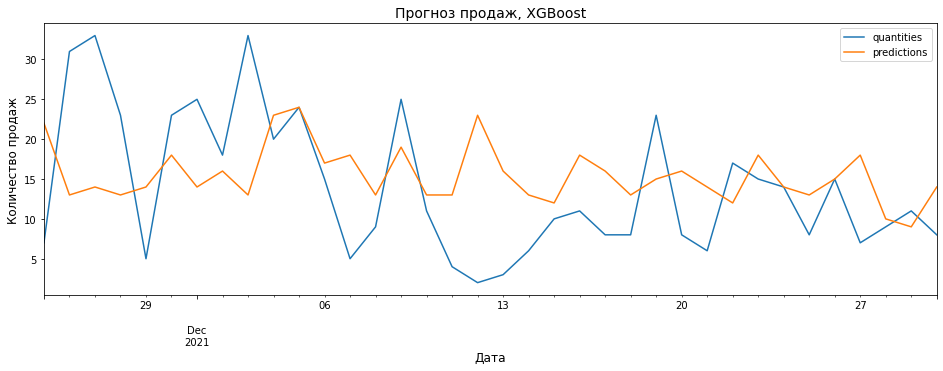

In [52]:
for i in range(len(models)):
    graph = y_test.copy()
    predictions_sales = pd.DataFrame(data = models[i].predict(X_test), columns = ['predictions'], index = X_test.index.copy())
    df_merged = pd.merge(graph, predictions_sales, how = 'left', left_index = True, right_index = True)
    df_merged['predictions'] = df_merged['predictions'].astype('int64')
    df_merged['2021-11-25':'2021-12-30'].plot(figsize=(16,5))
    plt.title('Прогноз продаж, {}'.format(models_names[i]), fontsize=14)
    plt.xlabel('Дата',  fontsize=12)
    plt.ylabel('Количество продаж', fontsize=12)

<a id='Прогнозирование будущих продаж.'>

###  Прогнозирование будущих продаж с использованием класических ML алгоритмов

Перед прогнозированием необходимо обучить модели на всех имеющихся данных.

In [53]:
df = raw_data.copy()

In [54]:
df['dates']= pd.to_datetime(df['dates'])
df = df.set_index('dates')

In [55]:
make_features(df, 21)

In [56]:
full_train = df.dropna()

In [57]:
X_full_train = full_train.drop(['quantities'], axis=1)
y_full_train = full_train['quantities']

In [58]:
for model in models:
    model.fit(X_full_train, y_full_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.006155
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.001016 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 23
[LightGBM] [Info] Start training from score 26.135542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, 

26:	learn: 9.9334594	total: 25.2ms	remaining: 68.2ms
27:	learn: 9.8268811	total: 26.2ms	remaining: 67.4ms
28:	learn: 9.7296862	total: 27.2ms	remaining: 66.6ms
29:	learn: 9.6629455	total: 28.1ms	remaining: 65.6ms
30:	learn: 9.5890737	total: 29.1ms	remaining: 64.8ms
31:	learn: 9.5127996	total: 30ms	remaining: 63.8ms
32:	learn: 9.4438760	total: 30.9ms	remaining: 62.8ms
33:	learn: 9.3850144	total: 31.8ms	remaining: 61.7ms
34:	learn: 9.3168731	total: 32.7ms	remaining: 60.8ms
35:	learn: 9.2606257	total: 33.8ms	remaining: 60ms
36:	learn: 9.2223904	total: 34.8ms	remaining: 59.3ms
37:	learn: 9.1823089	total: 35.7ms	remaining: 58.3ms
38:	learn: 9.1185466	total: 36.7ms	remaining: 57.3ms
39:	learn: 9.0639761	total: 37.6ms	remaining: 56.4ms
40:	learn: 9.0178370	total: 38.6ms	remaining: 55.6ms
41:	learn: 8.9844853	total: 39.8ms	remaining: 55ms
42:	learn: 8.9474488	total: 40.8ms	remaining: 54.1ms
43:	learn: 8.9214061	total: 41.8ms	remaining: 53.1ms
44:	learn: 8.8841871	total: 42.7ms	remaining: 52.2ms

Добавим в данные о следующей неделе для дальнейшего прогнозирования.

In [59]:
future_values  = pd.DataFrame({'dates': ['2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03',
                                  '2022-01-04', '2022-01-05', '2022-01-06'],
                               'quantities': [0, 0, 0, 0, 0, 0, 0]})

In [60]:
df = raw_data.copy()

In [61]:
df = df.append(future_values, ignore_index=True)

In [62]:
df['dates']= pd.to_datetime(df['dates'])
df = df.set_index('dates')

In [63]:
make_features(df, 21)

In [64]:
def make_prediction(model, df, prediction_length):
    
    '''Functon makes prediction prediction_length defined.'''
    
    data = df.copy()
    
    predictions = []
    
    columns = ['dayofweek', 'dayofmonth','lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
               'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
               'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21']
    
    for i in range(1, prediction_length + 1):
        if i == prediction_length:
            pred = model.predict(data[-prediction_length-1+i:].loc[:, columns])
            data.iloc[-prediction_length-1+i:]['quantities'] = int(pred[0].round())
            predictions.append(int(pred[0].round()))
            
            
        else:
            pred = model.predict(data[-prediction_length-1+i:-prediction_length+i].loc[:, columns])
            data.iloc[-prediction_length-1+i:-prediction_length+i]['quantities'] = int(pred[0].round())
            predictions.append(int(pred[0].round()))
            
            for lag in range(1, prediction_length-i + 1):
                data['lag_{}'.format(lag)] = data['quantities'].shift(lag)
                
    return predictions

In [65]:
predictions = []
for model in models:
    predictions.append(make_prediction(model, df, 7))   

In [66]:
predictions = pd.DataFrame(predictions)
predictions = predictions.transpose()
predictions.columns = models_names
predictions.index = future_values['dates']

Получаем результат предсказания по каждой модели.

In [67]:
predictions

,Linear Regression,Random Forest Regression,Light GBM,Catboost,XGBoost
dates,,,,,
2021-12-31,12,12,12,13,10
2022-01-01,7,12,11,13,10
2022-01-02,8,12,11,13,5
2022-01-03,6,13,14,14,3
2022-01-04,7,14,11,14,14
2022-01-05,8,14,12,14,9
2022-01-06,8,15,17,15,17


Получим итоговый результат путем взвешивания ответов моделей по точности.

In [68]:
x1 = 0.3 # для более точных моделей
x2 = 0.175 # для менее точных моделей

In [69]:
result_classic_ml = pd.DataFrame()

In [70]:
result_classic_ml['dates'] = future_values['dates']

In [71]:
result_classic_ml['quantities'] = ( x1*np.array(predictions[models_names[0]]) + 
                                    x2*np.array(predictions[models_names[1]]) +
                                    x2*np.array(predictions[models_names[2]]) +
                                    x2*np.array(predictions[models_names[3]]) +
                                    x2*np.array(predictions[models_names[4]])  ).round()

Проверяем.

In [72]:
result_classic_ml

,dates,quantities
0,2021-12-31,12.0
1,2022-01-01,10.0
2,2022-01-02,10.0
3,2022-01-03,9.0
4,2022-01-04,11.0
5,2022-01-05,11.0
6,2022-01-06,14.0


In [73]:
result_classic_ml.to_csv('result_classic_ml.csv', index=False);

<a id='Вывод 2'>

### <p style="text-align:center"> Вывод </p>

##### В ходе работы с классическими ML алгоритмами выполнено:


___



1. Обучение классических ML алгоритмов, а именно Linear Regression, Random Forest Regression, Light GBM, Catboost и XGBoost. Все модели показали результаты выше результатов дамми-модели.


2. Тестирование классических ML алгоритмов. На тестовой выборке все модели показали схожие результаты, с небольшим отрывом у Linear Regression, Random Forest Regression и Catboost. Также были выведены сравнительные графики предсказаний.


3. Прогнозирование будущих продаж. Модели были переобучены на всем объеме данных и сделаны прогнозы на следующую за временным рядом неделю.



___


## Часть 3. Работа с нейронными сетями

<a id='Создание нейронной сети с использованием LSTM.'>

###  Создание нейронной сети с использованием LSTM

In [74]:
df = raw_data.copy()

In [75]:
lstm_data = df.iloc[:, 1:2].values

In [76]:
data_train, data_valid = train_test_split(lstm_data, shuffle=False, test_size=0.3)
data_valid, data_test = train_test_split(data_valid, shuffle=False, test_size=0.5)

In [77]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [78]:
scaler.fit(data_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

Функция для создания датасета удовлетворяющего условиям нейронной сети.

In [79]:
def scale_and_create_dataset(dataset, lookback, test=False):
    
    '''The function scales provided dataset and makes lists of features and targets.'''
    
    data = scaler.transform(dataset)
    features, targets = [], []
    if test == False:
        for i in range(lookback, len(data)):
            features.append(data[i-lookback:i, 0])
            targets.append(data[i, 0])
    else:
        for i in range(lookback, len(data)):
            features.append(data[i-lookback:i, 0])
            targets.append(dataset[i, 0])
            
    return np.array(features), np.array(targets)

Обучаться сеть будет на данных три предыдущие недели.

In [80]:
x_train, y_train = scale_and_create_dataset(data_train, lookback=21)

In [81]:
x_valid, y_valid = scale_and_create_dataset(data_valid, lookback=21)

In [82]:
x_test, y_test = scale_and_create_dataset(data_test, lookback=21, test=True)

Добавляем размерность, еще одно условие обучения LSTM слоев.

In [83]:
def reshape_dataset(dataset):
    
    '''The function just reshapes dataset.'''
    
    return np.reshape(dataset, (dataset.shape[0], dataset.shape[1], 1))

In [84]:
x_train = reshape_dataset(x_train)

In [85]:
x_valid = reshape_dataset(x_valid)

In [86]:
x_test = reshape_dataset(x_test)

In [87]:
def create_model(input_shape):
    
    '''
        The function creates neural network model with provided layers. 
        Input shape - shape of the lookback-array.
    
    '''
    model = Sequential()

    model.add(LSTM(units = 10, return_sequences=True,
               kernel_initializer='glorot_uniform',
               input_shape=input_shape))

    model.add(LSTM(units=10, kernel_initializer='glorot_uniform',
               return_sequences=True))

    model.add(LSTM(units=10, kernel_initializer='glorot_uniform'))

    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [88]:
input_shape = (x_train.shape[1], 1)

In [89]:
model = create_model(input_shape)

In [90]:
def train_model(model, features, target, validation_data=None, batch_size=None, epochs=None):
    
    '''The function trains neural network model.'''

    model.fit(features, target, validation_data=validation_data, 
              batch_size=batch_size, epochs=epochs, shuffle=False)

    return model

In [91]:
model = train_model(model, features=x_train, target=y_train, 
                    batch_size=3, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
76/76 [==============================] - 11s 52ms/step - loss: 0.1352 - val_loss: 0.0085
Epoch 2/5
76/76 [==============================] - 2s 21ms/step - loss: 0.0501 - val_loss: 0.0086
Epoch 3/5
76/76 [==============================] - 2s 21ms/step - loss: 0.0458 - val_loss: 0.0083
Epoch 4/5
76/76 [==============================] - 2s 21ms/step - loss: 0.0441 - val_loss: 0.0080
Epoch 5/5
76/76 [==============================] - 2s 22ms/step - loss: 0.0417 - val_loss: 0.0079


<a id='Тестирование нейронной сети.'>


###  Тестирование нейронной сети

In [92]:
y_pred = model(x_test)

In [93]:
predicted_sales = scaler.inverse_transform(y_pred)

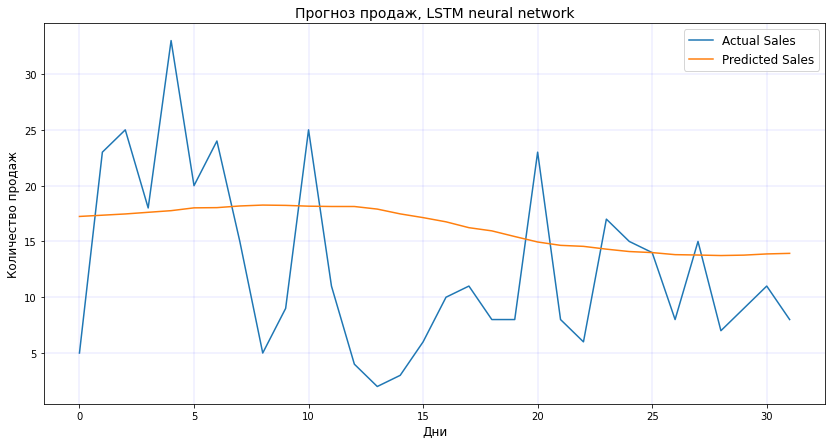

In [94]:
plt.figure(figsize = (14, 7))
plt.plot(y_test, label = 'Actual Sales')
plt.plot(predicted_sales, label = 'Predicted Sales')
plt.title('Прогноз продаж, LSTM neural network', fontsize=14)
plt.xlabel('Дни',  fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.legend(fontsize=12)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.show()

В целом модель научилась определять тренд, но не справляется с пиками.

Посчитаем точность полученной модели.

In [95]:
rmse_nn = np.sqrt(mean_squared_error(y_test, predicted_sales)).round(3)

In [96]:
print('RMSE модели нейронной сети:', end = ' ')
print(rmse_nn)

RMSE модели нейронной сети: 8.28


<a id='Прогнозирование будущих продаж с использованием нейронной сети.'>

### Прогнозирование будущих продаж с использованием нейронной сети

Как и с классическими алгоритмами, нам необходимо обучить нейронную сеть на полном объеме данных.

In [97]:
scaler.fit(lstm_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [98]:
full_x_train, full_y_train = scale_and_create_dataset(lstm_data, lookback=21)

In [99]:
full_x_train = reshape_dataset(full_x_train)

In [100]:
input_shape = (full_x_train.shape[1], 1)

In [101]:
model = create_model(input_shape)

In [102]:
model = train_model(model, features=full_x_train, target=full_y_train, batch_size=3, epochs=5)

Epoch 1/5
111/111 [==============================] - 9s 20ms/step - loss: 0.0754
Epoch 2/5
111/111 [==============================] - 2s 20ms/step - loss: 0.0310
Epoch 3/5
111/111 [==============================] - 2s 20ms/step - loss: 0.0296: 0s - l
Epoch 4/5
111/111 [==============================] - 2s 22ms/step - loss: 0.0287
Epoch 5/5
111/111 [==============================] - 2s 20ms/step - loss: 0.0280


In [103]:
def make_prediction_lstm(dataset, prediction_length):
    
    '''Functon makes prediction prediction_length defined, but for lstm nn.'''
    
    predicted = []
    
    data = scaler.transform(dataset)
    
    for i in range(1, prediction_length + 1):
        sample = data[-prediction_length:]
        sample = np.reshape(sample, (1, prediction_length, 1))
        y_pred = model(sample)
        predicted.append(np.array(y_pred)[0])
        data = np.append(data, np.array(y_pred)[0])
    
    predicted_sales = scaler.inverse_transform(predicted)
    
    return predicted_sales

Применяем функцию.

In [104]:
prediction_lstm = make_prediction_lstm(lstm_data, 7)

In [105]:
rounded_prediction_lstm = []
for value in prediction_lstm.tolist():
    value = int(round(value[0]))
    rounded_prediction_lstm.append(value)

In [106]:
result_neural_network = pd.DataFrame()
result_neural_network['dates'] = future_values['dates']
result_neural_network['quantities'] = rounded_prediction_lstm

Проверяем.

In [107]:
result_neural_network

,dates,quantities
0,2021-12-31,10
1,2022-01-01,10
2,2022-01-02,10
3,2022-01-03,10
4,2022-01-04,10
5,2022-01-05,10
6,2022-01-06,10


In [108]:
result_neural_network.to_csv('result_neural_network.csv', index=False);

<a id='Вывод 3'>

###  Вывод 

##### В ходе работы с нейронной сетью выполнено:


___



1. Создание и тестирование нейронной сети с использованием LSTM слоев. Выведен сравнительный график предсказанных и фактических значений. Модель неплохо обучилась, но не улавливает пики. Зависимость в данных достаточно простая, поэтому точности моделей близки к точности дамми-модели.


2. Прогнозирование будущих продаж нейронной сетью. 


___


## Часть 4. Использование базовых моделей

<a id='Использование модели SARIMAX'>

### Использование модели SARIMAX

Теперь попробуем предсказать значения продаж моделью SARIMAX.

In [109]:
df = raw_data.copy()

In [110]:
model = sm.tsa.statespace.SARIMAX(df['quantities'], order=(1, 1, 1), seasonal_order=(1,1,1,12))

In [111]:
results = model.fit()

In [112]:
df = df.append(future_values, ignore_index=True)

In [113]:
df['forecast'] = results.predict(start=353, end=360, dynamic=True)

In [114]:
result_sarimax = pd.DataFrame()
result_sarimax['dates'] = future_values['dates']
result_sarimax['quantities'] = df['forecast'][-7:].values.round()

Проверяем.

In [115]:
result_sarimax

,dates,quantities
0,2021-12-31,10.0
1,2022-01-01,11.0
2,2022-01-02,9.0
3,2022-01-03,10.0
4,2022-01-04,13.0
5,2022-01-05,9.0
6,2022-01-06,11.0


In [116]:
result_sarimax.to_csv('result_sarimax.csv', index=False);

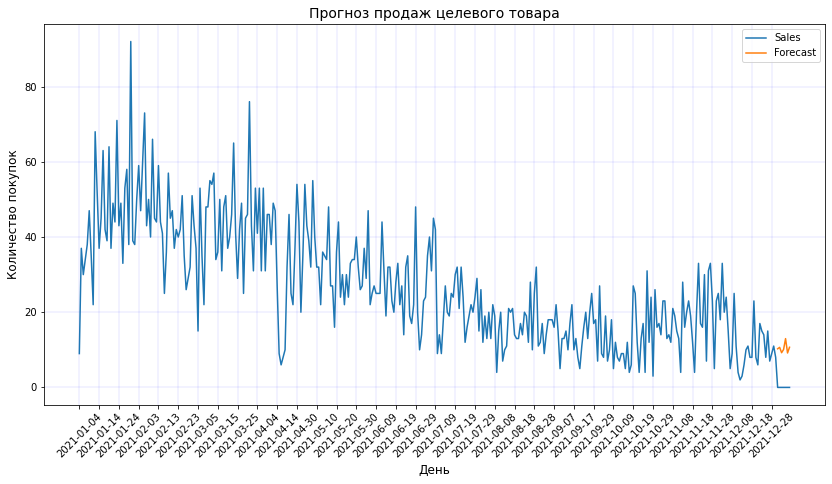

In [117]:
plt.figure(figsize = (14, 7))
plt.plot(df['quantities'], label =  'Sales');
plt.plot(df['forecast'], label = 'Forecast');
plt.xticks(range(0, df.shape[0], 10), df['dates'].loc[::10], rotation = 45)
plt.title('Прогноз продаж целевого товара', fontsize=14)
plt.xlabel('День', fontsize=12)
plt.ylabel('Количество покупок', fontsize=12)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.legend(fontsize=10)
plt.show()

<a id='Вывод 4'>

###  Общий вывод о проделанной работе

##### В ходе работы по прогнозированию продаж целевого товара для супермаркета X выполнено:


___


1. Предварительный анализ полученного временного ряда. Ряд разбит на составляющие, произведены проверки на стационарность.


2. Работа с классическими ML алгоритмами, их тестирование и прогнозирование будущих продаж. 


3. Работа по созданию и тестированию нейронной сети с использованием LSTM слоев, прогнозирование будущих продаж. 


4. Использование модели SARIMAX для предсказания будущих продаж целевого товара.


___
